<a href="https://colab.research.google.com/github/LukegCashman/Cashman_ECGR4105/blob/main/LC_HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# SECTION 0: Initialize Data Sets

import torch
import torch.optim as optim
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch.nn as nn

In [ ]:
# Prepare temperature data set
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0];
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4];

# Convert variables to tensors
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

In [ ]:
# Pull the csv file for Housing from github
url = 'https://raw.githubusercontent.com/HamedTabkhi/Intro-to-ML/main/Dataset/Housing.csv'

# Read the data from Housing
df = pd.read_csv(url)

# Convert strings to numbers
df['mainroad'] = df['mainroad'].map({'yes':1 ,'no':0})
df['guestroom'] = df['guestroom'].map({'yes':1 ,'no':0})
df['basement'] = df['basement'].map({'yes':1 ,'no':0})
df['hotwaterheating'] = df['hotwaterheating'].map({'yes':1 ,'no':0})
df['airconditioning'] = df['airconditioning'].map({'yes':1 ,'no':0})
df['prefarea'] = df['prefarea'].map({'yes':1 ,'no':0})
df['furnishingstatus'] = df['furnishingstatus'].map({'furnished':1 ,'semi-furnished':0.5,'unfurnished':0})

# Print Housing to confirm there are no issues
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,1.0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,1.0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,0.5
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,1.0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,1.0


In [ ]:
# randomize the training and validation data split for Housing set
np.random.seed(0)
housing_train, housing_validate = train_test_split(df, train_size = 0.8, test_size = 0.2, random_state = 100)

In [ ]:
Y_train = torch.tensor(housing_train.values[:,0])
X_train = np.delete(housing_train, [0,5,6,7,8,9,11,12], axis=1)
Y_valid = torch.tensor(housing_validate.values[:,0])
X_valid = np.delete(housing_validate, [0,5,6,7,8,9,11,12], axis=1)

X_train_ext = np.delete(housing_train, 0, axis=1)
X_valid_ext = np.delete(housing_validate, 0, axis=1)

In [ ]:
# Standardize Housing training and validation sets
object = StandardScaler()
sd_train = object.fit_transform(X_train)
sd_validate = object.fit_transform(X_valid)

sd_train_ext = object.fit_transform(X_train_ext)
sd_validate_ext = object.fit_transform(X_valid_ext)

In [ ]:
# Convert data sets to tensors
trainH = torch.tensor(sd_train)
validH = torch.tensor(sd_validate)

trainH_ext = torch.tensor(sd_train_ext)
validH_ext = torch.tensor(sd_validate_ext)

train_ones = torch.ones((436,1))
valid_ones = torch.ones((109,1))

TH = torch.cat((trainH,train_ones), -1)
VH = torch.cat((validH,valid_ones), -1)
THA = torch.cat((trainH_ext,train_ones), -1)
VHA = torch.cat((validH_ext,valid_ones), -1)

# Convert from doubles to floats
train_housing = TH.float()
train_housing_ext = THA.float()
valid_housing = VH.float()
valid_housing_ext = VHA.float()
train_output = Y_train.float()
valid_output = Y_valid.float()

In [ ]:
# SECTION 1: Problem 1

# Define nonlinear model
def model(t_u, w2, w1, b):
  return w2*t_u**2 + w1*t_u + b

In [ ]:
# Define loss function
def loss_fn(t_p, t_c):
  squared_diffs = (t_p - t_c)**2
  return squared_diffs.mean()

In [ ]:
# Split training and validation sets
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 1, 10,  2,  7,  6,  4,  0,  9,  5]), tensor([8, 3]))

In [ ]:
# Seperate training and validation variables and normalize
train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]

val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]

train_t_un = 0.1 * train_t_u
val_t_un = 0.1 * val_t_u

In [ ]:
def final_training_loop(n_epochs, optimizer, params, train_t_u, val_t_u, train_t_c, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u, *params)
        train_loss = loss_fn(train_t_p, train_t_c)

        val_t_p = model(val_t_u, *params)
        val_loss = loss_fn(val_t_p, val_t_c)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        if epoch <= 3 or epoch % 500 == 0:
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
                  f" Validation loss {val_loss.item():.4f}")

    return params

In [ ]:
params = torch.tensor([1.0, 1.0, 0.0], requires_grad=True)
learning_rate = 0.0001;
optimizer = optim.SGD([params], lr=learning_rate)
n_epochs = 5000;

In [ ]:
final_training_loop(n_epochs, optimizer, params, train_t_un, val_t_un, train_t_c, val_t_c)

# Adam, Validation Loss = 4.8626 (epoch = 5000, learning rate = 0.01)
# SGD, Validation Loss = 2.5063 (epoch = 5000, learning rate = 0.0001)

Epoch 1, Training loss 522.6550, Validation loss 1364.9213
Epoch 2, Training loss 361.8160, Validation loss 916.2089
Epoch 3, Training loss 251.7214, Validation loss 613.1797
Epoch 500, Training loss 10.9313, Validation loss 12.7147
Epoch 1000, Training loss 9.3385, Validation loss 8.9454
Epoch 1500, Training loss 8.0459, Validation loss 6.4226
Epoch 2000, Training loss 6.9969, Validation loss 4.8577
Epoch 2500, Training loss 6.1456, Validation loss 4.0214
Epoch 3000, Training loss 5.4546, Validation loss 3.7330
Epoch 3500, Training loss 4.8938, Validation loss 3.8497
Epoch 4000, Training loss 4.4387, Validation loss 4.2600
Epoch 4500, Training loss 4.0692, Validation loss 4.8767
Epoch 5000, Training loss 3.7692, Validation loss 5.6322


tensor([ 0.5819, -0.9231, -0.9511], requires_grad=True)

In [ ]:
seq_model = torch.ones((70))
seq_model2 = torch.ones((11))

for i in range(20, 90):
  seq_model[i - 20] = 0.01*(params[0]*i**2 + params[1]*i + params[2])

In [ ]:
for i in range(0, 10):
  seq_model2[i] = 0.01*(params[0]*t_u[i]**2 + params[1]*t_u[i] + params[2])

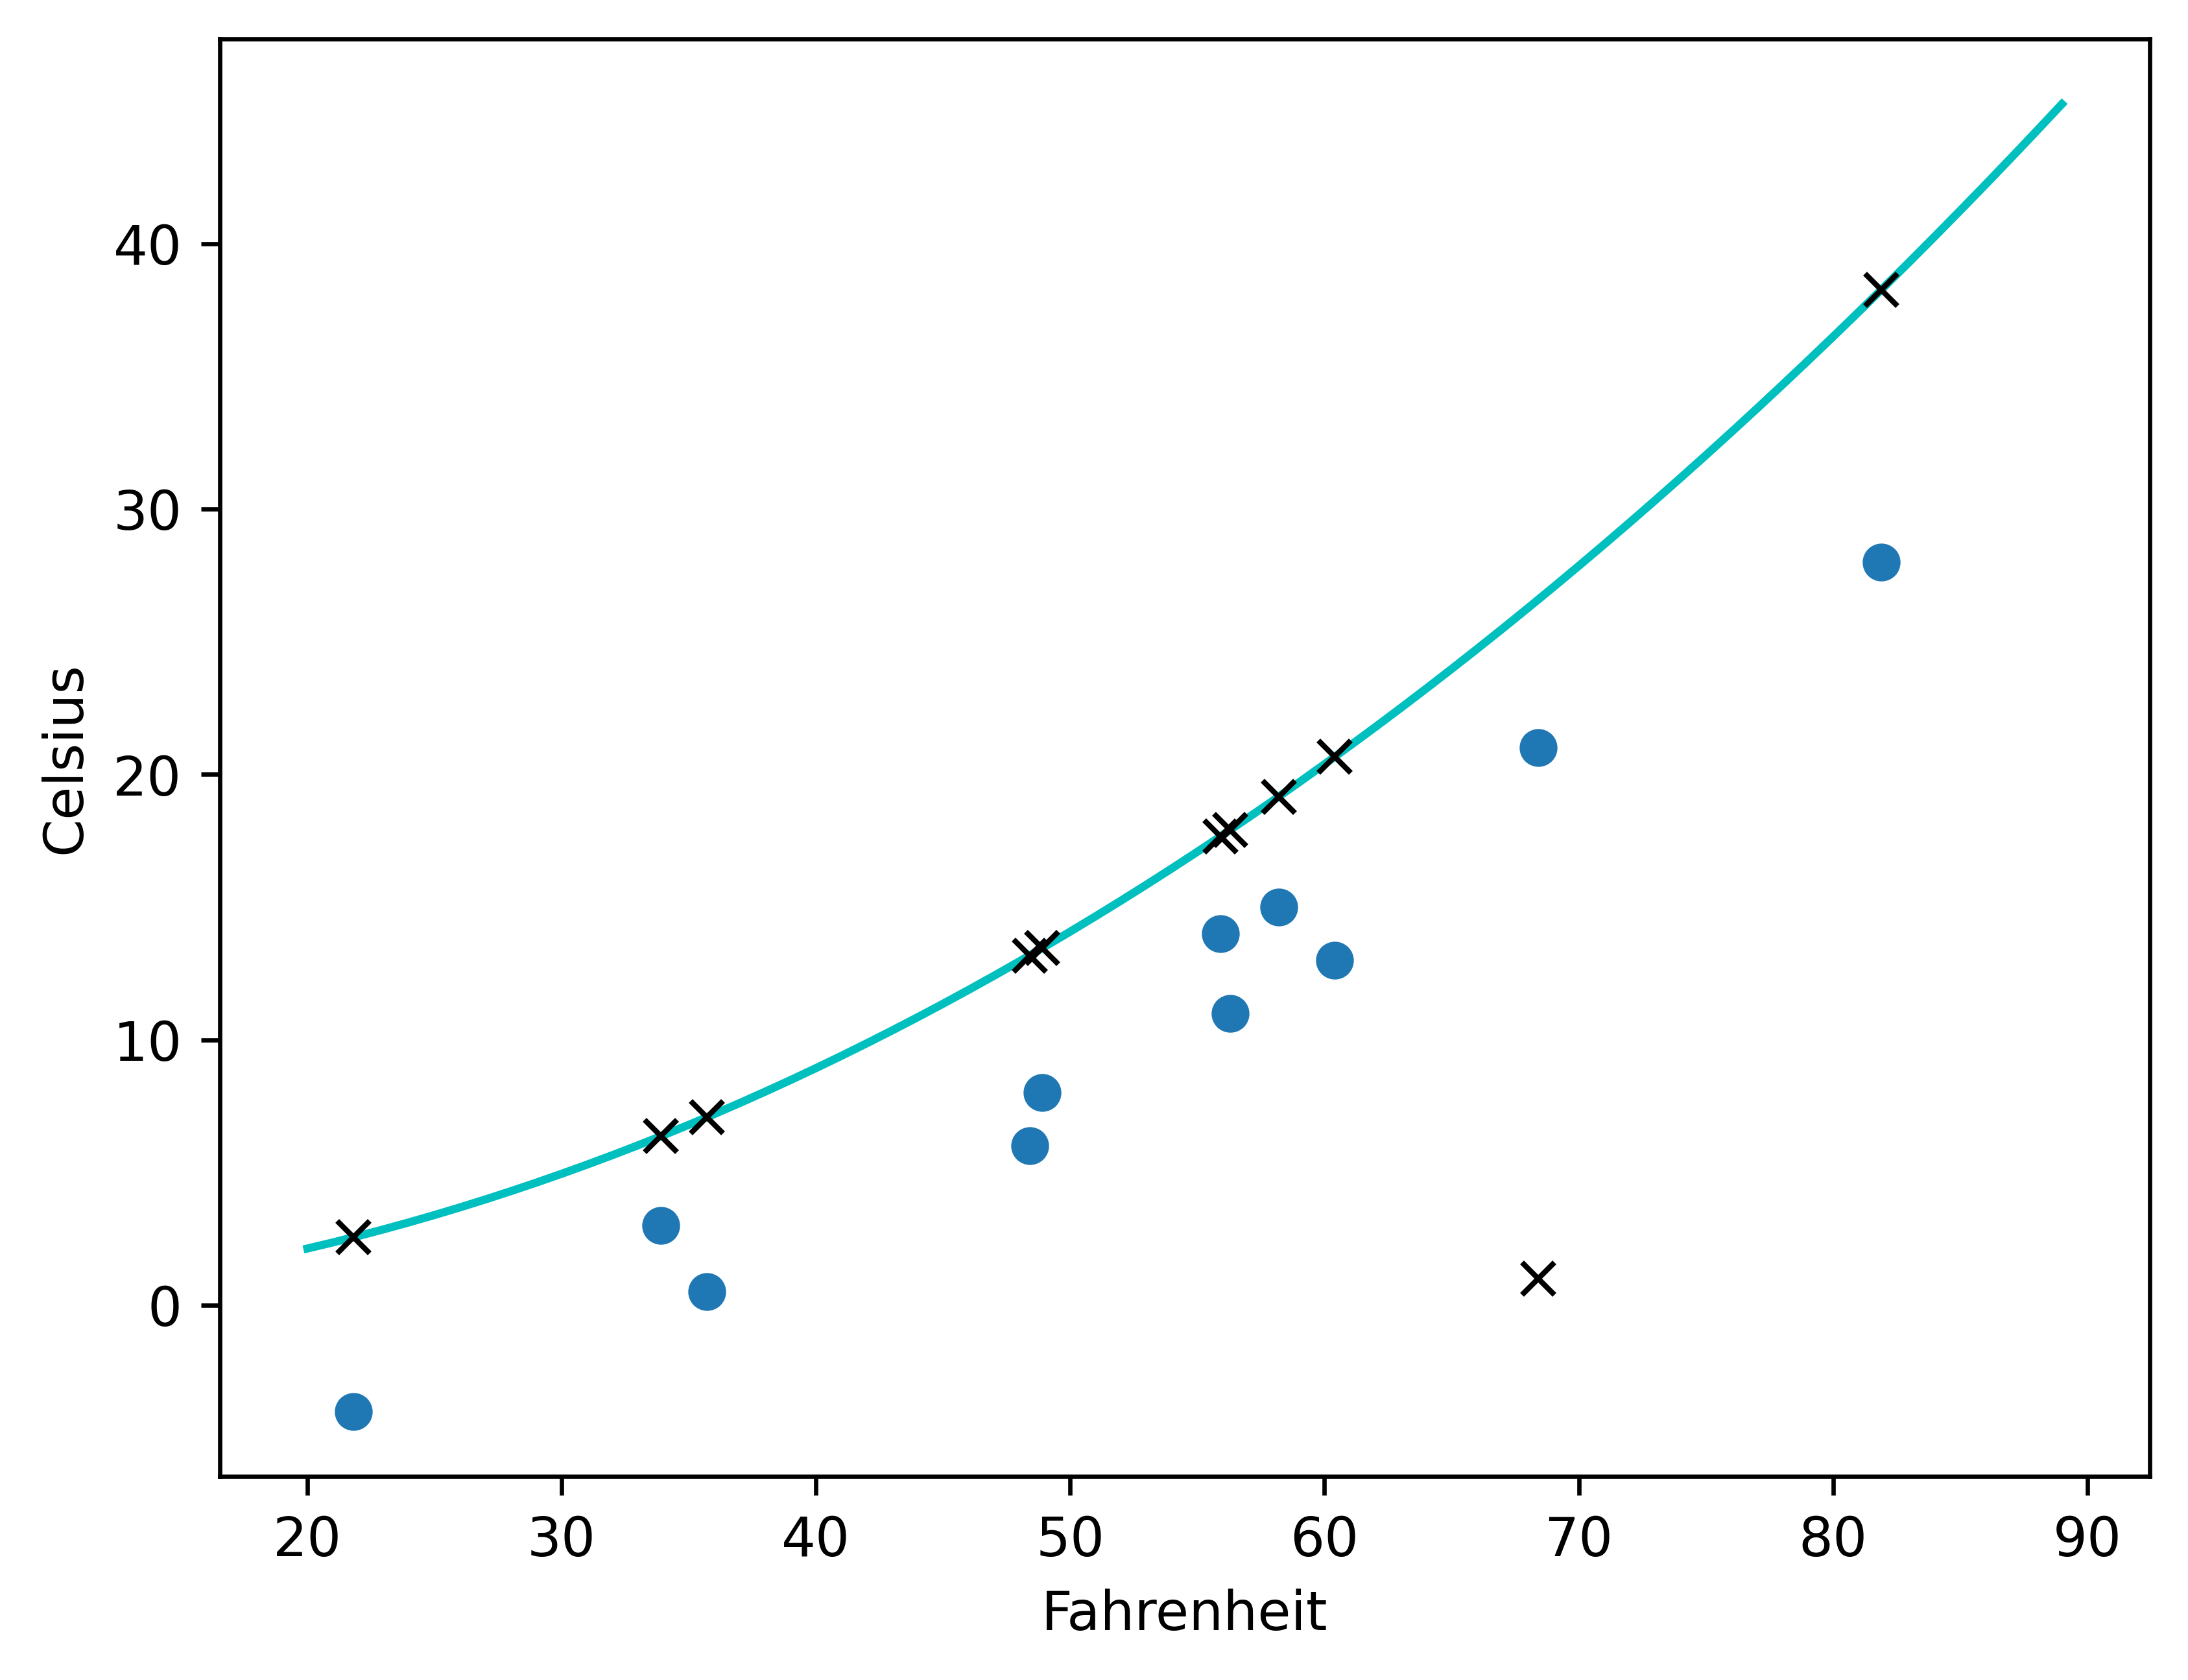

In [ ]:
t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=600)

plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model.detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model2.detach().numpy(), 'kx')

In [ ]:
# SECTION 2: Problem 2

linear_model = nn.Linear(6, 1)
linear_model(valid_housing)

tensor([[ 0.2035],
        [-1.1464],
        [-1.1585],
        [-0.2089],
        [-0.5505],
        [ 0.1604],
        [-1.9552],
        [-1.3284],
        [ 0.1454],
        [-0.8417],
        [ 0.3415],
        [-0.6997],
        [-0.6940],
        [-2.3730],
        [-0.1778],
        [-2.1043],
        [-2.4309],
        [-0.4250],
        [-0.4168],
        [-0.3393],
        [-0.0703],
        [-0.2066],
        [-0.1576],
        [ 0.2806],
        [ 0.3734],
        [ 0.7564],
        [-1.1030],
        [-1.1750],
        [-1.7859],
        [-1.3549],
        [ 0.7565],
        [-0.0263],
        [ 0.4919],
        [ 0.6780],
        [-0.7572],
        [-0.1616],
        [-0.4340],
        [ 0.2213],
        [ 0.6812],
        [-0.0703],
        [ 0.6964],
        [-0.8857],
        [-1.1383],
        [ 0.2847],
        [ 0.4173],
        [ 0.1818],
        [-0.2393],
        [-0.3365],
        [ 0.5342],
        [-1.5519],
        [ 0.8029],
        [-1.1997],
        [-0.

In [ ]:
# Housing weight
linear_model.weight

Parameter containing:
tensor([[-0.3794, -0.3089, -0.2547, -0.1608, -0.2635, -0.0984]],
       requires_grad=True)

In [ ]:
# Housing bias
linear_model.bias

Parameter containing:
tensor([-0.3631], requires_grad=True)

In [ ]:
def lin_training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train) # <1>
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val) # <1>
        loss_val = loss_fn(t_p_val, t_c_val)

        optimizer.zero_grad()
        loss_train.backward() # <2>
        optimizer.step()

        if epoch == 1 or epoch % 500 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")

In [ ]:
from collections import OrderedDict

seq_modelH = nn.Sequential(OrderedDict([('hidden_linear', nn.Linear(6, 30)), ('hidden_activation', nn.Tanh()), ('output_linear', nn.Linear(30, 1))]))

seq_modelH

Sequential(
  (hidden_linear): Linear(in_features=6, out_features=30, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=30, out_features=1, bias=True)
)

In [ ]:
for name, param in seq_modelH.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([30, 6])
hidden_linear.bias torch.Size([30])
output_linear.weight torch.Size([1, 30])
output_linear.bias torch.Size([1])


In [ ]:
optimizer = optim.SGD(seq_modelH.parameters(), lr=0.01)
n_epochs = 5000;

lin_training_loop(n_epochs, optimizer, seq_modelH, nn.MSELoss(), train_housing, valid_housing, train_output, valid_output)

print()
print(linear_model.weight)
print(linear_model.bias)

# Adam, loss = 25158295224320.0000, (lr = 0.01)
# SGD,  loss =  3478582722560.0000, (lr = 0.01)

Epoch 1, Training loss 3479851761664.0000, Validation loss 3551429394432.0000
Epoch 500, Training loss 3479185129472.0000, Validation loss 3550794481664.0000
Epoch 1000, Training loss 3478871343104.0000, Validation loss 3550573756416.0000
Epoch 1500, Training loss 3478724018176.0000, Validation loss 3550520279040.0000
Epoch 2000, Training loss 3478654287872.0000, Validation loss 3550527619072.0000
Epoch 2500, Training loss 3478621257728.0000, Validation loss 3550552260608.0000
Epoch 3000, Training loss 3478605791232.0000, Validation loss 3550576115712.0000
Epoch 3500, Training loss 3478597402624.0000, Validation loss 3550594727936.0000
Epoch 4000, Training loss 3478593470464.0000, Validation loss 3550607572992.0000
Epoch 4500, Training loss 3478590586880.0000, Validation loss 3550615699456.0000
Epoch 5000, Training loss 3478589538304.0000, Validation loss 3550619631616.0000

Parameter containing:
tensor([[ 2.4417e-02, -8.1564e-03, -1.0574e-02,  2.5151e-02, -4.9803e-02,
         -5.5848

In [ ]:
# SECTION 3: Problem 3

linear_model = nn.Linear(13, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=0.001)
n_epochs = 5000;

lin_training_loop(n_epochs, optimizer, linear_model, nn.MSELoss(), train_housing_ext, valid_housing_ext, train_output, valid_output)

print()
print(linear_model.weight)
print(linear_model.bias)

# Adam, loss = 25158295224320.0000, (lr = 0.01)
# SGD,  loss =  3550488035328.0000, (lr = 0.001)
# Simple linear model ran better than sequence

Epoch 1, Training loss 26477600964608.0000, Validation loss 25158767083520.0000
Epoch 500, Training loss 3899820867584.0000, Validation loss 3783527497728.0000
Epoch 1000, Training loss 3486234443776.0000, Validation loss 3532788334592.0000
Epoch 1500, Training loss 3478720086016.0000, Validation loss 3547224604672.0000
Epoch 2000, Training loss 3478583246848.0000, Validation loss 3550047371264.0000
Epoch 2500, Training loss 3478581149696.0000, Validation loss 3550443208704.0000
Epoch 3000, Training loss 3478581149696.0000, Validation loss 3550488035328.0000
Epoch 3500, Training loss 3478581149696.0000, Validation loss 3550488035328.0000
Epoch 4000, Training loss 3478581149696.0000, Validation loss 3550488035328.0000
Epoch 4500, Training loss 3478581149696.0000, Validation loss 3550488035328.0000
Epoch 5000, Training loss 3478581149696.0000, Validation loss 3550488035328.0000

Parameter containing:
tensor([[ 2.4417e-02, -8.1564e-03, -1.0574e-02,  2.5151e-02, -4.9803e-02,
         -5.58